In [1]:
import os
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

### 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
data_path = 'C:/nlp/tensorflow-ml-nlp-tf2/5.TEXT_SIM/data_in/'

In [4]:
q1_data = np.load(open(data_path + 'train_q1.npy', 'rb'))
q2_data = np.load(open(data_path + 'train_q2.npy', 'rb'))
label = np.load(open(data_path + 'train_label.npy', 'rb'))
pre_config = json.load(open(data_path + 'data_configs.json', 'r'))

In [5]:
# 랜덤시드 고정

seed = 1234
tf.random.set_seed(seed)

In [6]:
model_name = 'malstm_similarity'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1

kargs = {
    'vocab_size': pre_config['vocab_size'],
    'embedding_dimension': 100,
    'lstm_dimension': 150,
}

### 모델

In [38]:
class MaLSTM(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(MaLSTM, self).__init__(name=model_name)
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm = layers.LSTM(units=kargs['lstm_dimension'])
        
    def call(self, x):
        x1, x2 = x
        x1 = self.embedding(x1)
        x2 = self.embedding(x2)
        x1 = self.lstm(x1)
        x2 = self.lstm(x2)
        
        x = tf.exp(-tf.reduce_sum(tf.abs(x1 - x2), axis=1))
        
        return x

In [39]:
model = MaLSTM(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [40]:
op = 'C:/nlp/tensorflow-ml-nlp-tf2/5.TEXT_SIM/data_out/'

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

checkpoint_path = op + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

C:/nlp/tensorflow-ml-nlp-tf2/5.TEXT_SIM/data_out/malstm_similarity -- Folder already exists 



In [41]:
history = model.fit((q1_data, q2_data), label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
2100/2100 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.7376
Epoch 00001: val_accuracy improved from -inf to 0.79071, saving model to C:/nlp/tensorflow-ml-nlp-tf2/5.TEXT_SIM/data_out/malstm_similarity\weights.h5
2100/2100 [==============================] - 412s 196ms/step - loss: 0.5283 - accuracy: 0.7376 - val_loss: 0.4749 - val_accuracy: 0.7907
Epoch 2/5
2100/2100 [==============================] - ETA: 0s - loss: 0.4029 - accuracy: 0.8197
Epoch 00002: val_accuracy improved from 0.79071 to 0.80235, saving model to C:/nlp/tensorflow-ml-nlp-tf2/5.TEXT_SIM/data_out/malstm_similarity\weights.h5
2100/2100 [==============================] - 406s 193ms/step - loss: 0.4029 - accuracy: 0.8197 - val_loss: 0.4642 - val_accuracy: 0.8023
Epoch 3/5
2100/2100 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.8470
Epoch 00003: val_accuracy did not improve from 0.80235
2100/2100 [==============================] - 418s 199ms/step - loss: 0.3546

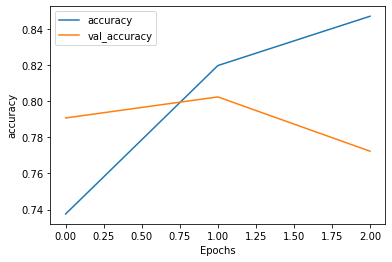

In [42]:
plot_graphs(history, 'accuracy')

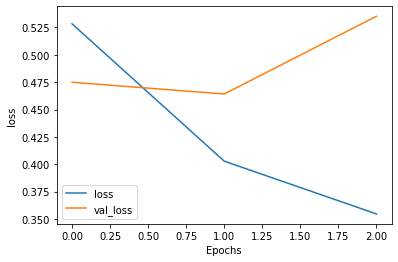

In [43]:
plot_graphs(history, 'loss')

In [48]:
TEST_Q1_DATA_FILE = 'test_q1.npy'
TEST_Q2_DATA_FILE = 'test_q2.npy'
TEST_ID_DATA_FILE = 'test_id.npy'

test_q1_data = np.load(open(data_path + TEST_Q1_DATA_FILE, 'rb'))
test_q2_data = np.load(open(data_path + TEST_Q2_DATA_FILE, 'rb'))
test_id_data = np.load(open(data_path + TEST_ID_DATA_FILE, 'rb'), allow_pickle=True)

In [49]:
SAVE_FILE_NM = 'weights.h5'
model.load_weights(os.path.join(op, model_name, SAVE_FILE_NM))

In [50]:
predictions = model.predict((test_q1_data, test_q2_data), batch_size=BATCH_SIZE)

In [51]:
output = pd.DataFrame( data={"test_id":test_id_data, "is_duplicate": list(predictions)} )
output.to_csv(op+"lstm_predict(add).csv", index=False, quoting=3)